In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb


In [187]:
data = pd.read_csv('train_spam.csv')
data['is_spam'] = data['text_type'] == 'spam'

Посмотрим сначала с какими данными мы работаем

In [8]:
data['is_spam'].value_counts()

is_spam
False    11469
True      4809
Name: count, dtype: int64

Посмотрим на самые частые слова в обоих классах. При анализе не будем учитывать стоп слова из английского.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/damircanysev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/damircanysev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


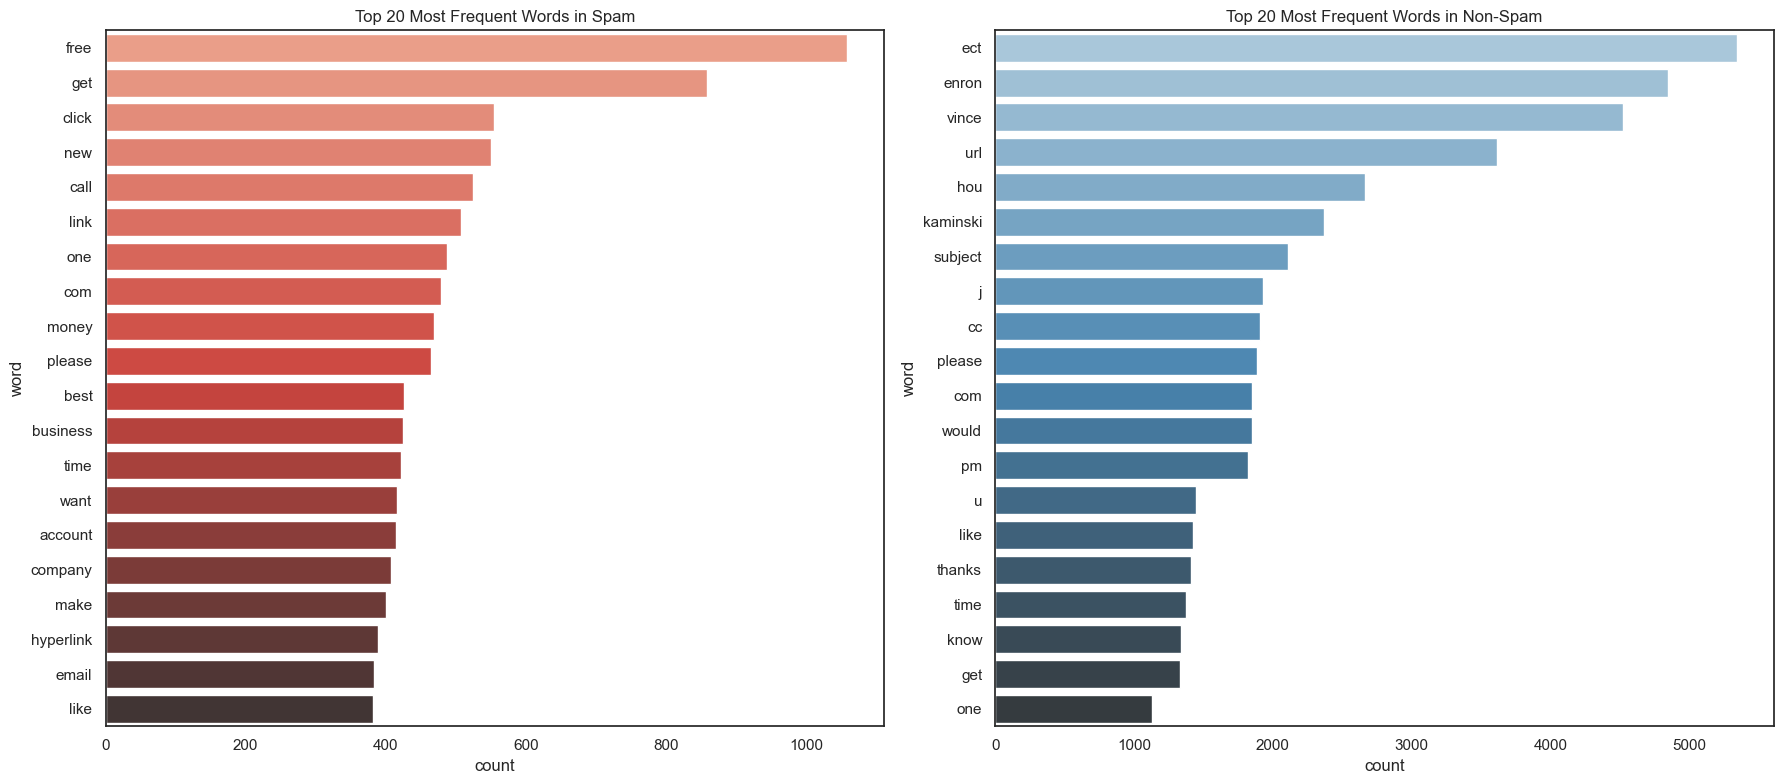

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter

stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if
                      word.isalpha() and word not in stop_words]
    return filtered_words


data['tokens'] = data['text'].apply(preprocess_text)
spam_tokens = data[data['is_spam'] == True]['tokens'].sum()
non_spam_tokens = data[data['is_spam'] == False]['tokens'].sum()

spam_word_freq = Counter(spam_tokens)
non_spam_word_freq = Counter(non_spam_tokens)

spam_common_words = spam_word_freq.most_common(20)
non_spam_common_words = non_spam_word_freq.most_common(20)

df_spam_words = pd.DataFrame(spam_common_words, columns=['word', 'count'])
df_non_spam_words = pd.DataFrame(non_spam_common_words, columns=['word', 'count'])
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=df_spam_words, palette='Reds_d', hue='word')
plt.title('Top 20 Most Frequent Words in Spam')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=df_non_spam_words, palette='Blues_d', hue='word')
plt.title('Top 20 Most Frequent Words in Non-Spam')

plt.tight_layout()
plt.show()

Здесь становится понятно, что часто письма содержат какой-то не очень связный текст и как будто были сгенерированы не очень умной языковой моделью, которая очень любит Винсета Каминьски. Возможно, это было сделано специально, чтобы было проще обучить модель.

----
Посмотрим на распределение длины писем в обоих классах

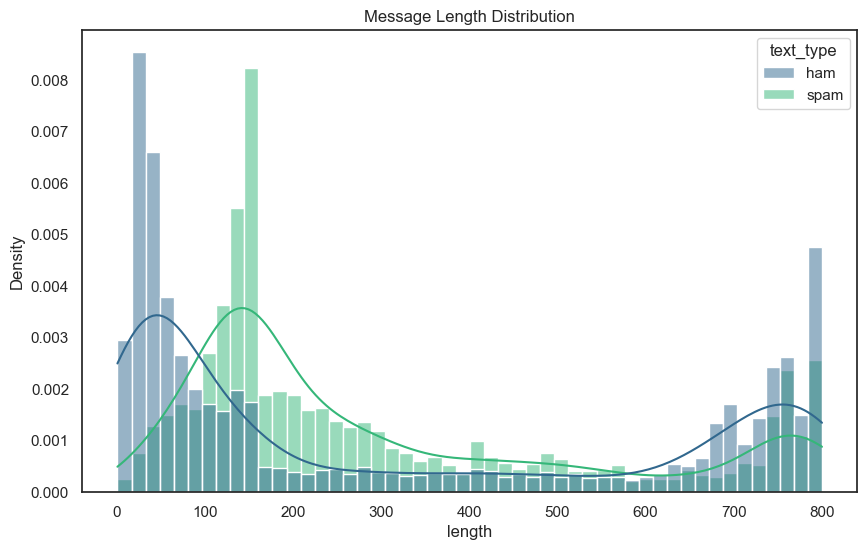

In [253]:
def add_length(df):
    df['length'] = df['text'].apply(len)


add_length(data)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='length', hue='text_type', bins=50, kde=True, palette='viridis', stat='density',
             common_norm=False)
plt.title('Message Length Distribution')
plt.show()

Похоже на бимодальное. Видно, что пики у классов различаются -- это хорошо и в принципе можно объяснить: чаще всего в спам письмах нужно вводить читающего в контекст, обычное же письмо может быть частью переписки, из-за чего в этом классе будет больше коротких писем

----
Теперь посчитаем полярность писем. Это делается путем сопоставления каждому слову оценки его полярности. Потом считается суммах по всему тексту и нормализуется на количество распознанных токенов. 

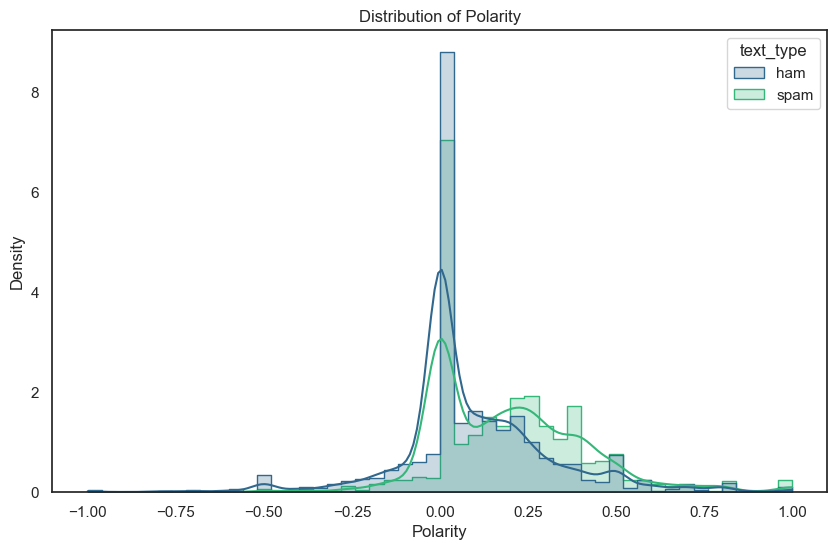

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob


def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


def add_polarity(df):
    df['polarity'] = df['text'].apply(get_polarity)


add_polarity(data)

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='polarity', hue='text_type', element='step', palette='viridis', kde=True, bins=50,
             stat='density', common_norm=False)
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Density')
plt.show()

In [16]:
average_sentiment = data.groupby('text_type')['polarity'].mean()
average_sentiment

text_type
ham     0.093369
spam    0.190594
Name: polarity, dtype: float64

Видно, что разница между классами тоже наблюдается.
С помощью `textblob` можно посчитать еще несколько полезных фичей, например количество глаголов, существительных, прилагательных, субъективность (считается тем же образом что и полярность)

In [254]:
def extract_features(text):
    blob = TextBlob(text)
    pos_counts = {'NN': 0, 'VB': 0, 'JJ': 0}
    for word, pos in blob.tags:
        if pos.startswith('NN'):
            pos_counts['NN'] += 1
        elif pos.startswith('VB'):
            pos_counts['VB'] += 1
        elif pos.startswith('JJ'):
            pos_counts['JJ'] += 1

    words = blob.words.lower()
    ttr = len(set(words)) / len(words) if words else 0

    subjectivity = blob.sentiment.subjectivity

    return pos_counts['NN'], pos_counts['VB'], pos_counts['JJ'], len(words), ttr, subjectivity


def add_textblob_features(df):
    df[['noun_count', 'verb_count', 'adj_count', 'words_count', 'ttr', 'subjectivity']] = data[
        'text'].apply(lambda x: pd.Series(extract_features(x)))
    for count_var in ['noun', 'verb', 'adj']:
        var = f'{count_var}_count'
        ratio_var = f'{count_var}_ratio'
        df[ratio_var] = df[var] / df['words_count']


add_textblob_features(data)

In [255]:
features = ['noun_ratio', 'verb_ratio', 'adj_ratio', 'ttr', 'subjectivity']

mean_features = data.groupby('text_type')[features].mean()
print(mean_features)

           noun_ratio  verb_ratio  adj_ratio       ttr  subjectivity
text_type                                                           
ham          0.346384    0.179941   0.101375  0.832656      0.347081
spam         0.414793    0.142764   0.107710  0.847966      0.395462


Теперь поизучаем текст на наличие конкретных паттернов, например количество смайликов, чисел и ссылок в обоих классах. Мы будем использовать TfidfVectorizer, который не сможет ухватить такие фичи

In [321]:
import re
import emoji


def count_urls(text):
    return len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))


def count_handles(text):
    return len(re.findall('@[\d\w]+', text))


def count_numbers(text):
    return len(re.findall(r'\d+', text))


def caps_proportion(text):
    if len(text) == 0:
        return 0
    else:
        return sum(1 for c in text if c.isupper()) / len(text)


def count_currency_symbols(text):
    pattern = r'[\$\€\£\¥]'
    return len(re.findall(pattern, text))


def count_emojis(text):
    return sum(1 for _ in emoji.emoji_list(text))


def punctuation_count(text):
    punctuations = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
    return sum(1 for char in text if char in punctuations)


stop_words = set(stopwords.words('english'))


def stop_words_count(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in stop_words)


def add_pattern_features(df):
    df['url_count'] = df['text'].apply(count_urls)
    df['number_count'] = df['text'].apply(count_numbers)
    df['caps_proportion'] = df['text'].apply(caps_proportion)
    df['emoji_count'] = df['text'].apply(count_emojis)
    df['emoji_ratio'] = df['emoji_count'] / df['length']
    df['handle_count'] = df['text'].apply(count_handles)
    df['currency_count'] = df['text'].apply(count_currency_symbols)
    df['punctuation_count'] = df['text'].apply(punctuation_count)
    df['stop_words_count'] = df['text'].apply(stop_words_count)
    df['tokens_count'] = df['text'].apply(lambda x: len(x.split()))
    df['stop_words_ratio'] = df['stop_words_count'] / df['tokens_count']
    df['punctuation_ratio'] = df['punctuation_count'] / df['length']
    df['number_ratio'] = df['number_count'] / df['tokens_count']


add_pattern_features(data)

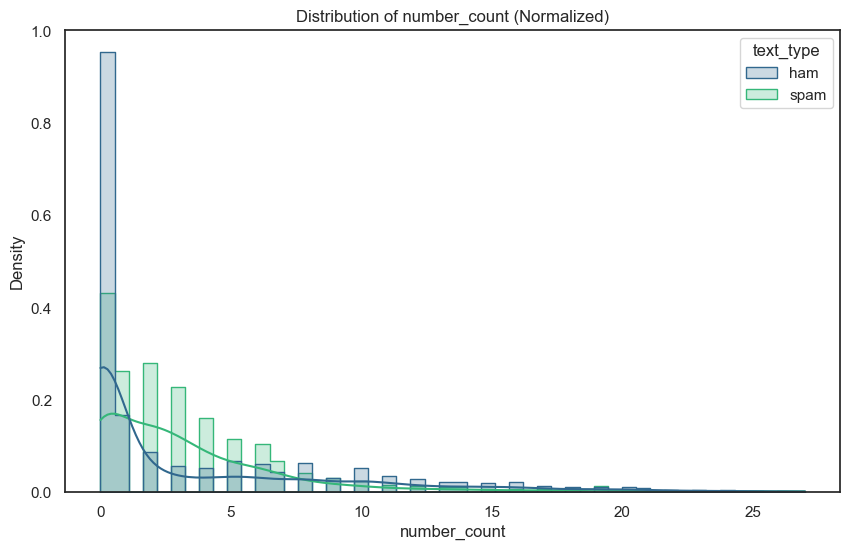

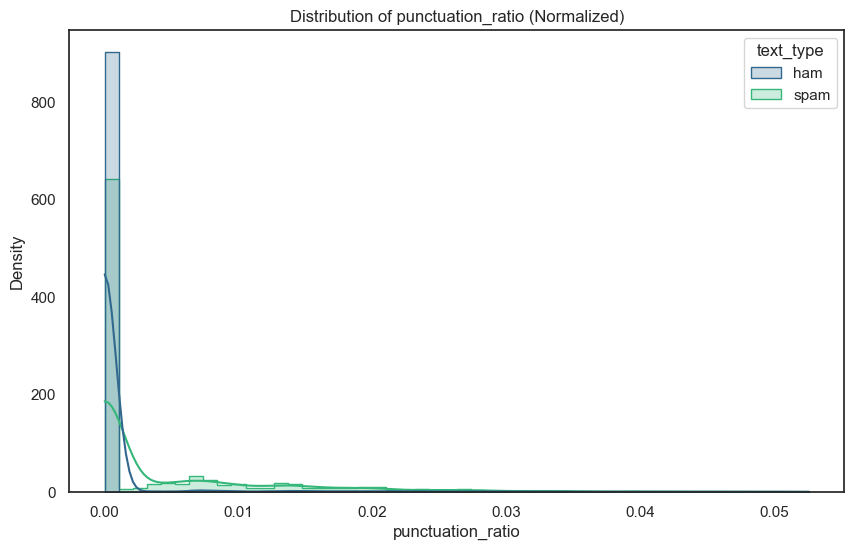

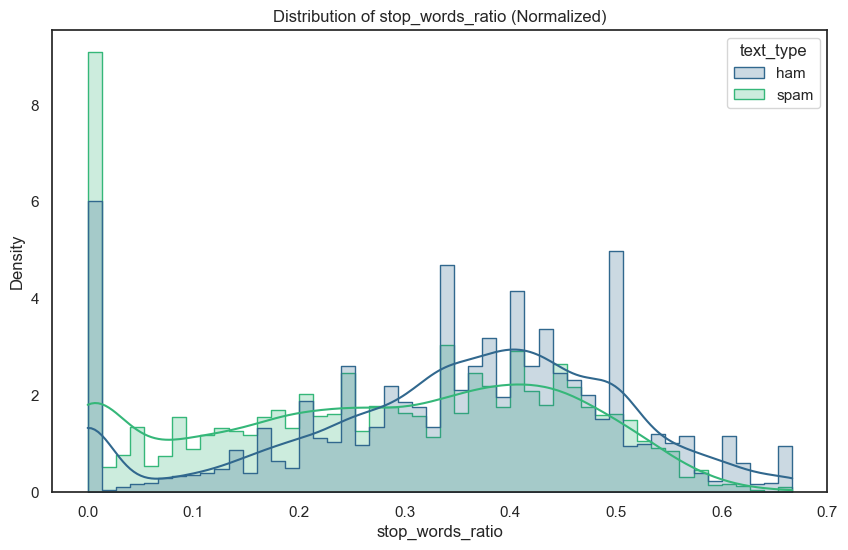

In [257]:
for feature in ['number_count', 'punctuation_ratio', 'stop_words_ratio']:
    plt.figure(figsize=(10, 6))
    subset = data[data[feature] <= data[feature].quantile(0.99)]
    sns.histplot(data=subset, x=feature, hue='text_type', element='step', palette='viridis', kde=True, bins=50,
                 stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} (Normalized)')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

In [322]:
features = ['number_count', 'caps_proportion', 'emoji_count', 'url_count', 'handle_count', 'currency_count',
            'punctuation_ratio', 'stop_words_ratio', 'emoji_ratio']
mean_features = data.groupby('text_type')[features].mean()
print(mean_features)

           number_count  caps_proportion  emoji_count  url_count  \
text_type                                                          
ham            3.774087         0.000239     0.021100   0.000000   
spam           3.972136         0.004142     2.418798   0.000208   

           handle_count  currency_count  punctuation_ratio  stop_words_ratio  \
text_type                                                                      
ham            0.008545        0.002267           0.002509          0.353083   
spam           0.150135        0.221460           0.004448          0.277788   

           emoji_ratio  
text_type               
ham           0.000749  
spam          0.010179  


Видно что в спаме больше цифр, смайликов и урлов, отношение заглавных букв к прописным тоже выше

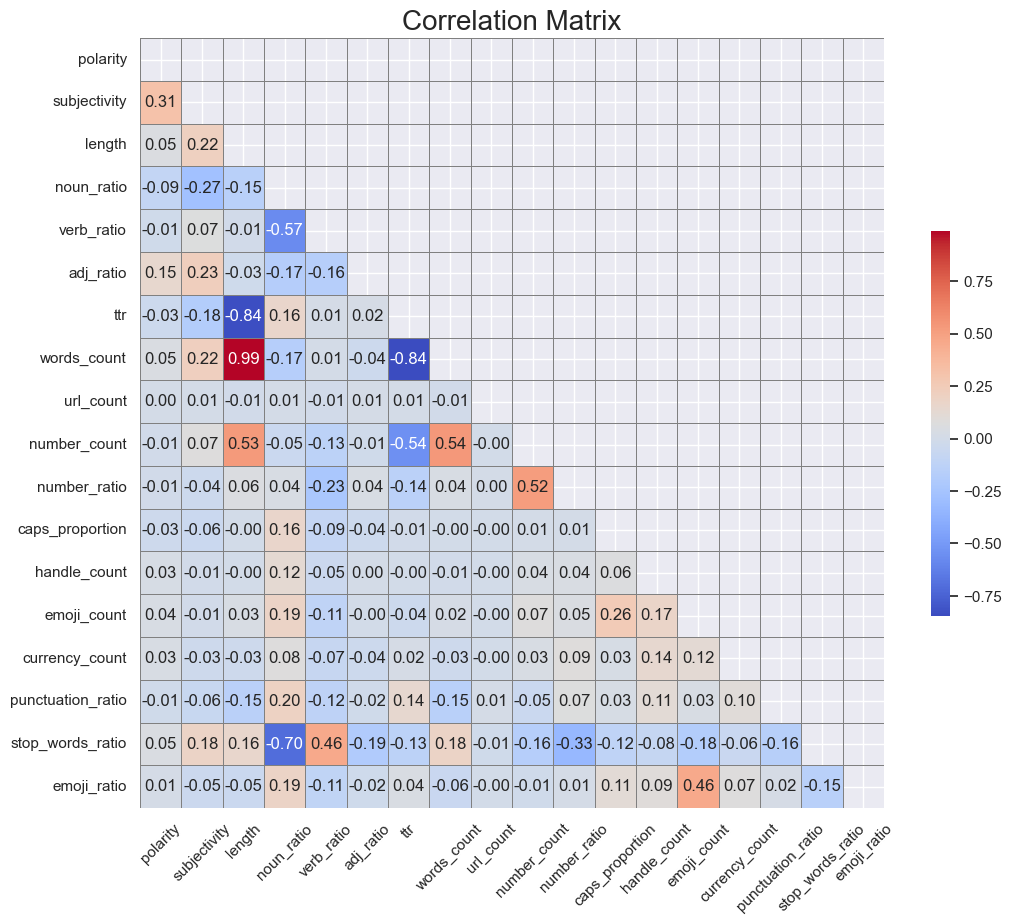

In [323]:
all_features = ['polarity', 'subjectivity', 'length', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'ttr', 'words_count',
                'url_count', 'number_count', 'number_ratio', 'caps_proportion', 'handle_count', 'emoji_count',
                'currency_count', 'punctuation_ratio', 'stop_words_ratio', 'emoji_ratio']


def plot_feature_correlation_matrix(features):
    correlation_matrix = data[features].corr()

    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                cbar_kws={'shrink': .5}, linewidths=.5, linecolor='gray')
    plt.title('Correlation Matrix', fontsize=20)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


plot_feature_correlation_matrix(all_features)

Выкинем некоторые фичи с большой корреляцией.

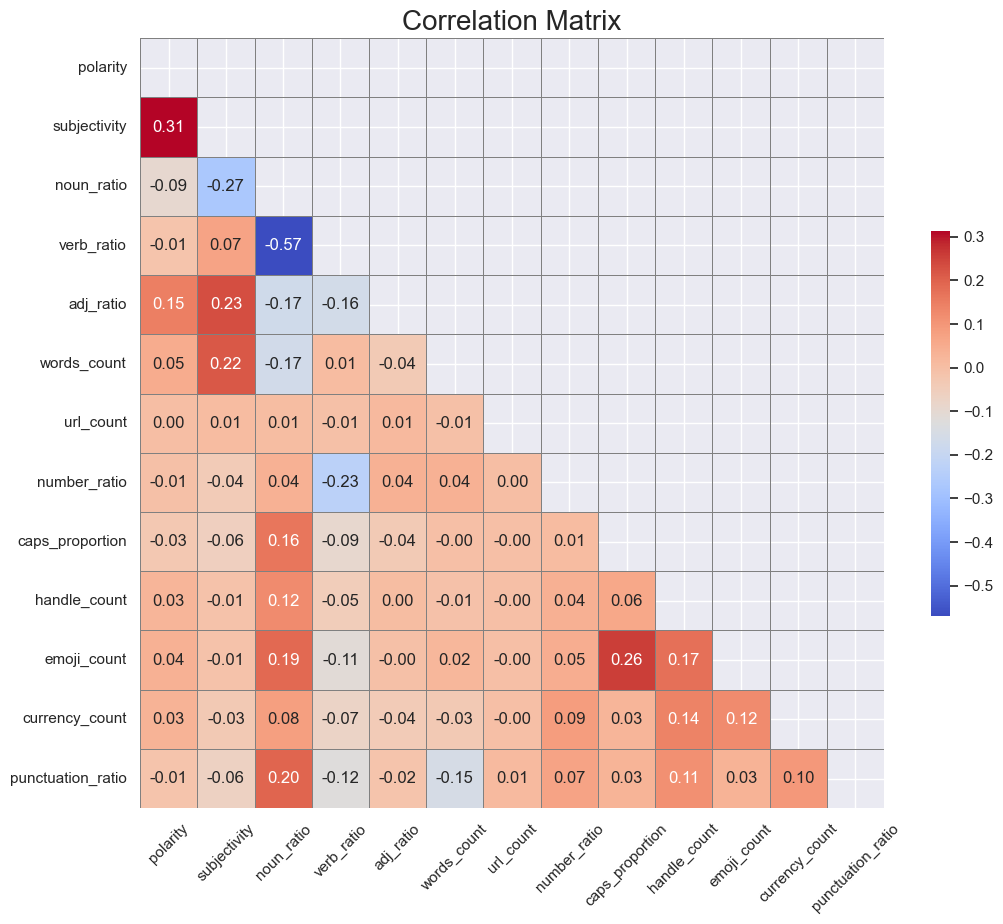

In [359]:
no_text_features = ['polarity', 'subjectivity', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'words_count',
                    'url_count', 'number_ratio', 'caps_proportion', 'handle_count', 'emoji_count', 'currency_count',
                    'punctuation_ratio']
plot_feature_correlation_matrix(no_text_features)

----
Обучим что-нибудь

In [185]:
data.head(10)

,text_type,text,is_spam,url_count,number_count,caps_proportion,emoji_count,handle_count,tokens,length,...,subjectivity,noun_ratio,verb_ratio,adj_ratio,currency_count,punctuation_count,stop_words_count,tokens_count,stop_words_ratio,punctuation_ratio
0,ham,make sure alex knows his birthday is over in f...,False,0,0,0.0,0,0,"[make, sure, alex, knows, birthday, fifteen, m...",86,...,0.944444,0.187500,0.250000,0.187500,0,0,6,16,0.375000,0.0
1,ham,a resume for john lavorato thanks vince i will...,False,0,5,0.0,0,0,"[resume, john, lavorato, thanks, vince, get, m...",520,...,0.399824,0.391753,0.134021,0.092784,0,0,33,97,0.340206,0.0
2,spam,plzz visit my website moviesgodml to get all m...,True,0,0,0.0,5,0,"[plzz, visit, website, moviesgodml, get, movie...",126,...,0.600000,0.318182,0.136364,0.181818,0,0,8,22,0.363636,0.0
3,spam,urgent your mobile number has been awarded wit...,True,0,5,0.0,0,0,"[urgent, mobile, number, awarded, prize, guara...",139,...,1.000000,0.260870,0.173913,0.173913,1,0,7,23,0.304348,0.0
4,ham,overview of hr associates analyst project per ...,False,0,5,0.0,0,0,"[overview, hr, associates, analyst, project, p...",733,...,0.394015,0.472441,0.157480,0.102362,0,0,28,127,0.220472,0.0
5,spam,i am so greatful to mrs valerie dodson for hel...,True,0,0,0.0,0,0,"[greatful, mrs, valerie, dodson, helping, chan...",183,...,0.629293,0.303030,0.181818,0.090909,0,0,15,33,0.454545,0.0
6,ham,url url date not supplied government employees...,False,0,0,0.0,0,0,"[url, url, date, supplied, government, employe...",156,...,0.200000,0.307692,0.192308,0.192308,0,0,9,26,0.346154,0.0
7,spam,welcome to jefferson pilot s gateway to wealth...,True,0,0,0.0,0,0,"[welcome, jefferson, pilot, gateway, wealth, o...",800,...,0.488655,0.325397,0.166667,0.126984,0,0,49,126,0.388889,0.0
8,ham,looks like your ham corpus by and large has to...,False,0,0,0.0,0,0,"[looks, like, ham, corpus, large, jeremy, url,...",419,...,0.622449,0.282353,0.152941,0.094118,0,0,43,85,0.505882,0.0
9,ham,how are you with moneyas in to youmoney aint a...,False,0,0,0.0,0,0,"[moneyas, youmoney, aint, thinghow, sha]",67,...,0.000000,0.214286,0.285714,0.000000,0,0,9,14,0.642857,0.0


In [360]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

features = no_text_features + ['text']

X = data[features]
y = data['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)


def add_vectorizer_features(x, vectorizer):
    x_text = vectorizer.transform(x['text'])
    x_numeric = x.drop('text', axis=1).values
    x_sparse = csr_matrix(x_numeric)
    return hstack([x_sparse, x_text])


vectorizer.fit_transform(X_train['text'])
X_train = add_vectorizer_features(X_train, vectorizer)
X_test = add_vectorizer_features(X_test, vectorizer)

## Log Reg

In [361]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(random_state=52, solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9833069881914458


## Random Forest

In [362]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=500, random_state=52)
random_forest.fit(X_train, y_train)
y_pred_proba = random_forest.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.986835868625559


## GBM

In [363]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'is_unbalance': True,
}

gbm = lgb.train(params, lgb_train, valid_sets=lgb_test, num_boost_round=500)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9897206046381136


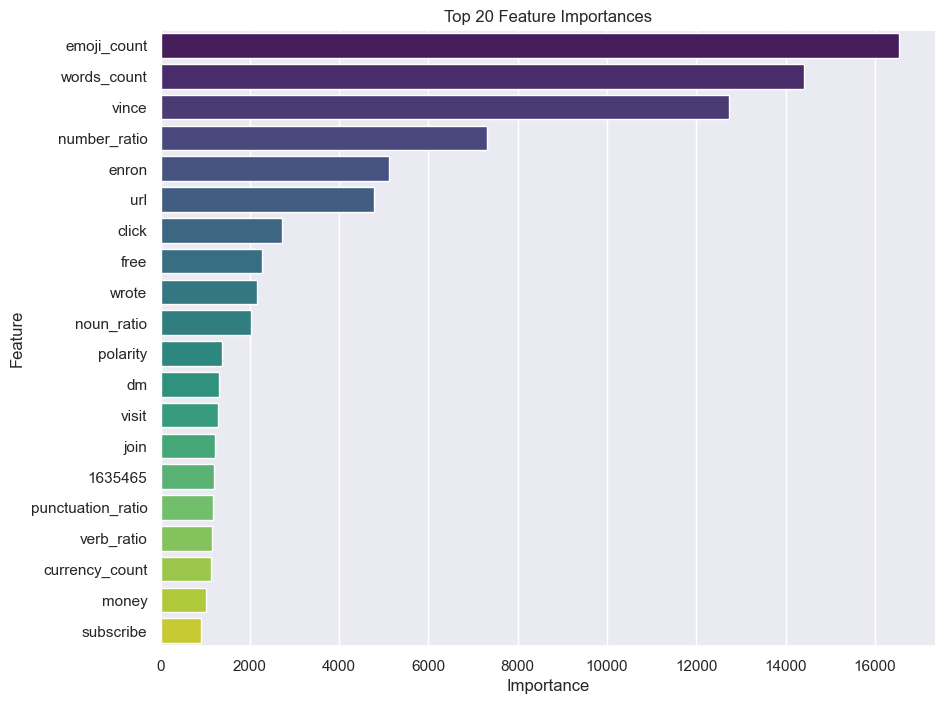

In [364]:
feature_importances = gbm.feature_importance(importance_type='gain')
feature_names = vectorizer.get_feature_names_out().tolist()

feature_names = no_text_features + feature_names

assert len(feature_importances) == len(feature_names)

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances_df.head(20), x='Importance', y='Feature', palette='viridis', hue='Feature')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Еще раз можно заметить синтетическую природу текстов по vince и enron. Оба слова входят в тройку самых частых слов из не-спам писем

Посчитаем корреляцию между предиктами и соберем простой ансамбль

In [365]:
rf_preds = random_forest.predict_proba(X_test)[:, 1]
log_reg_preds = log_reg.predict_proba(X_test)[:, 1]
lgbm_preds = gbm.predict(X_test)
predictions = np.vstack([rf_preds, log_reg_preds, lgbm_preds])
correlation_matrix = np.corrcoef(predictions)
correlation_matrix

array([[1.        , 0.93845791, 0.94722257],
       [0.93845791, 1.        , 0.91573852],
       [0.94722257, 0.91573852, 1.        ]])

In [366]:
def predict(rf_model, logreg_model, gbm_model, x):
    rf_preds = rf_model.predict_proba(x)[:, 1]
    log_reg_preds = logreg_model.predict_proba(x)[:, 1]
    lgbm_preds = gbm_model.predict(x)
    sum_preds = (rf_preds + log_reg_preds + lgbm_preds) / 3
    return sum_preds

In [367]:
preds = predict(random_forest, log_reg, gbm, X_test)
roc_auc = roc_auc_score(y_test, preds)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9908551564627712


Даже с таким простым ансамблем результат улучшился

----
Посмотрим, где модель ошиблась

In [368]:
y_pred = (preds > 0.5).astype(int)
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred.flatten()})
misclassified = results[results['actual'] != results['predicted']]
data.loc[misclassified.index][['text_type', 'text']].head(15)

,text_type,text
2684,spam,add logos and tones to your cell phone 1575332...
12660,spam,upside pressure signals institutional interest...
9586,spam,need instagram followers likes
5891,ham,the february issue of reactions is now live on...
1420,spam,85233 freeringtonereply real
9883,spam,dating online?
2503,spam,heatt kills hello cbs a mythicize p news a r o...
9209,spam,join now
12246,ham,with an investment of 500 you will earn 10000 ...
2215,ham,important news my heart4 sale 100discount plzi...


Текущие модели не знают ничего про семантическую роль каждого токена. Так как мы используем TfidfVectorizer, они ориентируются на частоту слов. В случаях выше некоторые письма можно было бы обработать правильно, если учитывать смысл текста. Попробуем обучить LSTM модель для этого

## LSTM

In [125]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate

additional_features = no_text_features

X_train, X_test, y_train, y_test = train_test_split(data, data['is_spam'], test_size=0.2, random_state=52)

max_sequence_length = 100
vocabulary_size = 10000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train['text'])
X_train_sequences = tokenizer.texts_to_sequences(X_train['text'])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
scaler = StandardScaler()
X_train_additional = scaler.fit_transform(X_train[additional_features])
text_input = Input(shape=(max_sequence_length,))
additional_features_input = Input(shape=(X_train_additional.shape[1],))
text_embedding = Embedding(input_dim=vocabulary_size, output_dim=3)(text_input)
lstm_out = LSTM(units=5)(text_embedding)
combined_input = concatenate([lstm_out, additional_features_input])
output = Dense(1, activation='sigmoid')(combined_input)

model = Model(inputs=[text_input, additional_features_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

X_train_final = [X_train_padded, X_train_additional]

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 100, 3)    │     60,000 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 5)         │        180 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 19)        │          0 │ lstm_12[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         20 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,200 (235.16 KB)

 Trainable params: 60,200 (235.16 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
class RocAucCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_epoch_end(self, _, logs):
        y_pred = self.model.predict(self.x)
        roc_auc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_auc_val = roc_auc_score(self.y_val, y_pred_val)

        print('\rroc_auc: %s - roc_auc_val: %s' % (str(round(roc_auc, 4)), str(round(roc_auc_val, 4))))
        logs['roc_auc'] = roc_auc
        logs['roc_auc_val'] = roc_auc_val


X_test_sequences = tokenizer.texts_to_sequences(X_test['text'])
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)
X_test_additional = scaler.transform(X_test[additional_features])
X_test_final = [X_test_padded, X_test_additional]
roc_auc_callback = RocAucCallback(training_data=(X_train_final, y_train), validation_data=(X_test_final, y_test))
model.fit(X_train_final, y_train, epochs=10, batch_size=32, validation_data=(X_test_final, y_test),
          callbacks=[roc_auc_callback])

Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
roc_auc: 0.9593 - roc_auc_val: 0.9475                                                                                                    
407/407 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6164 - loss: 0.6549 - val_accuracy: 0.8894 - val_loss: 0.3072 - roc_auc: 0.9593 - roc_auc_val: 0.9475
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
roc_auc: 0.9823 - roc_auc_val: 0.9703                                                                                                    
407/407 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8852 - loss: 0.3054 - val_accuracy: 0.9315 - val_loss: 0.2133 - roc_auc: 0.9823 - roc_auc_val: 0.9703
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
roc_auc: 0.9905 - roc_auc_val: 0.9744                                                                                            

Очень мало данных для LSTM модели. Я пробовал разные гиперпараметры, модель начинает сильно переобучиться уже при десяти юнитах.

----
Сделаем скоринг для тестовых данных. Перед этим я обучил модели на всех данных.

In [310]:
test_data = pd.read_csv('test_spam.csv')

In [343]:
add_length(test_data)
add_pattern_features(test_data)
add_textblob_features(test_data)
add_polarity(test_data)

In [344]:
test_data = test_data[no_text_features + ['text']]
test_data_x = add_vectorizer_features(test_data, vectorizer)
test_data['score'] = predict(random_forest, log_reg, gbm, test_data_x)
test_data[['score', 'text']].to_csv('test_with_scores.csv', index=False)

/var/folders/sr/bjql_fmj53v566jt_mk71z580000gn/T/ipykernel_33436/1741769118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['score'] = predict(random_forest, log_reg, gbm, test_data_x)
